# Вычислительная математика. Лабораторная работа 7: решение краевой задачи

In [376]:
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.integrate import solve_ivp
import itertools

In [377]:
# y'' + f(x)y' + g(x)y = q(x)
def eulers_method(f, g, q, x_a, x_b, y_a, dy_a, steps_num):
    # z = y'
    # z' = q(x) - f(x)z - g(x)y
    step = np.abs(x_b - x_a) / steps_num
    steps = np.arange(x_a, x_b, step)
    current_y = y_a
    current_z = dy_a
    y = []
    z = []
    for current_x in steps:
        next_y = current_y + step * current_z
        next_z = current_z + step * (
            q(current_x) - f(current_x) * current_z - g(current_x) * current_y
        )
        y.append(next_y)
        z.append(next_z)
        current_y, current_z = next_y, next_z
    return {'x': steps,'y': np.array(y), 'dy/dx': np.array(z)}


# test
# y'' + y = 1
analytical_solution = lambda x: np.sin(x) + np.cos(x) + 1
numerical_solution = lambda steps: eulers_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=0., x_b=1.0, y_a = 2, dy_a = 1, steps_num=steps,
)

for steps in [2, 4, 8, 16, 32, 64]:
    precise = analytical_solution(1.0)
    numerical = numerical_solution(steps)['y'][-1]
    print(f'{precise} | {numerical} | {np.abs(precise - numerical)}')

2.381773290676036 | 2.75 | 0.36822670932396395
2.381773290676036 | 2.56640625 | 0.18463295932396395
2.381773290676036 | 2.4718132615089417 | 0.0900399708329056
2.381773290676036 | 2.4259511196707932 | 0.044177828994757196
2.381773290676036 | 2.403621799880494 | 0.021848509204458022
2.381773290676036 | 2.3926340381780338 | 0.010860747501997725


In [429]:
def tridiagonal(a, f):
    n = f.shape[0]
    if a.shape[0] != n or a.shape[1] != 3:
        print(a.shape[0], a.shape[1])
        raise RuntimeError('Matrix and/or vector dimensions do not correspond')
    u = np.zeros(n)
    v = np.zeros(n)
    u[0] = - a[0][2] / a[0][1]
    v[0] = f[0] / a[0][1]
    for i in range(1, n - 1):
        denum = a[i][1] + a[i][0]*u[i-1]
        u[i] = -a[i][2]/denum
        v[i] = (f[i] - a[i][0]*v[i-1])/denum
    x = np.zeros(n)
    x[n-1] = (f[n-1] - a[n-1][0] * v[n-2]) / (a[n-1][1] + a[n-1][0] * u[n-2])
    for i in range(n-2, -1, -1):
        x[i] = u[i]*x[i+1] + v[i]
    return x

5.078151819020595 1.0003214331606858 5
3.923828125


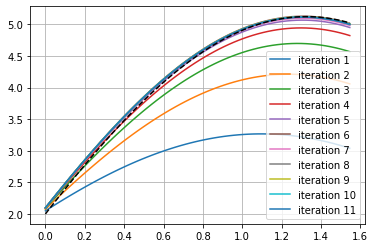

In [425]:
def shooting_method(f, g, q, x_a, x_b, y_a, y_b, steps_num, epsilon=0.001, quiet=False):
    # Overshoot if value > y_b, else Undershoot
    numerical_solution = lambda param: eulers_method(
        f=f, g=g, q=q, x_a=x_a, x_b=x_b, y_a = y_a, dy_a = param, steps_num=steps_num
    )
    S = numerical_solution(0.)['y'][-1]
    param_1 = 0.
    if (S > y_b):
        S_overshoot = S
        param_overshoot = 0.
        step_away = 1.
        while True:
            S_undershoot = numerical_solution(step_away)['y'][-1]
            if S_undershoot < y_b:
                param_2 = step_away
                param_undershoot = step_away
                break
            S_undershoot = numerical_solution(-step_away)['y'][-1]
            if S_undershoot < y_b:
                param_2 = -step_away
                param_undershoot = -step_away
                break
            step_away *= 2
    elif (S < y_b):
        S_undershoot = S
        param_undershoot = 0.
        step_away = 1.
        while True:
            S_overshoot = numerical_solution(step_away)['y'][-1]
            if S_overshoot > y_b:
                param_2 = step_away
                param_overshoot = step_away
                break
            S_overshoot = numerical_solution(-step_away)['y'][-1]
            if S_overshoot > y_b:
                param_2 = -step_away
                param_overshoot = -step_away
                break
            step_away *= 2
    else:
        if not quiet:
            print('Not gonna happend')
        return
    
    if not quiet:
        print(S_overshoot, S_undershoot, y_b)
    
    param_min = min(param_1, param_2)
    param_max = max(param_1, param_2)
    
    best_param, best_error = param_min, 10.**5
    num = 1
    while True:
        param_middle = np.average(np.array([param_overshoot, param_undershoot]))
        solution = numerical_solution(param_middle)
        S = solution['y'][-1]
        
        if not quiet:
            plt.plot(solution['x'], solution['y'], label=f"iteration {num}")
        num += 1
        
        if np.abs(S - y_b) < epsilon:
            break
        
        if S > y_b:
            param_overshoot = param_middle
        elif S < y_b:
            param_undershoot = param_middle
    
    if not quiet:
        print(param_middle)

        plt.plot(solution['x'], analytical_solution(solution['x']), "k--")
        plt.grid()
        plt.legend()
    return {'x': solution['x'],'y_numerical': solution['y'], 'y_analytical': analytical_solution(solution['x'])}
            

analytical_solution = lambda x: 4 * np.sin(x) + np.cos(x) + 1
solution = shooting_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=0., x_b=np.pi / 2, y_a = 2, y_b = 5, steps_num=64,
)

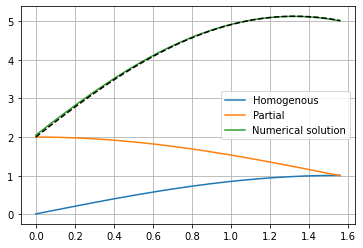

In [426]:
def shooting_linear_method(f, g, q, x_a, x_b, y_a, y_b, steps_num, epsilon=0.001, quiet=False):
    homogeneous_solution = eulers_method(
        f=f, g=g, q=lambda x: 0., x_a=x_a, x_b=x_b, y_a = 0., dy_a = 1., steps_num=steps_num
    )
    partial_solution = eulers_method(
        f=f, g=g, q=q, x_a=x_a, x_b=x_b, y_a = y_a, dy_a = 0., steps_num=steps_num
    )
    
    K = (-partial_solution['y'][-1] + y_b) / homogeneous_solution['y'][-1]
    
    solution = {
        'x': homogeneous_solution['x'],
        'y': K * homogeneous_solution['y'] + partial_solution['y'],
    }
    
    if not quiet:
        plt.plot(homogeneous_solution['x'], homogeneous_solution['y'], label='Homogenous')
        plt.plot(partial_solution['x'], partial_solution['y'], label='Partial')
        plt.plot(solution['x'], solution['y'], label='Numerical solution')

        plt.plot(solution['x'], analytical_solution(solution['x']), "k--")
        plt.grid()
        plt.legend()
    return {'x': solution['x'],'y_numerical': solution['y'], 'y_analytical': analytical_solution(solution['x'])}
            

analytical_solution = lambda x: 4 * np.sin(x) + np.cos(x) + 1
solution = shooting_linear_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=0., x_b=np.pi / 2, y_a = 2, y_b = 5, steps_num=128,
)

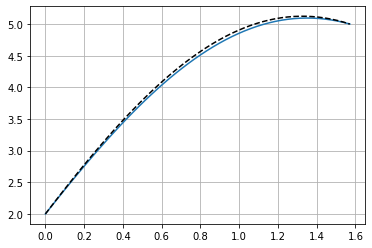

In [430]:
# Wy = F
def finite_diff_method(f, g, q, x_a, x_b, y_a, y_b, grid_size, quiet=False):
    W = np.zeros(shape=(grid_size, grid_size))
    F = np.zeros(shape=(grid_size,))
    x = np.linspace(x_a, x_b, grid_size)
    h = (x_a - x_b) / grid_size
    
    # Initial conditions
    W[0, 0] = 1
    F[0] = y_a
    
    W[-1, -1] = 1
    F[-1] = y_b
    
    for i in range(1, grid_size - 1):
        W[i, i-1] = 2 - h * f(x[i])
        W[i, i] = - 4 + 2 * g(x[i]) * (h ** 2)
        W[i, i+1] = 2 + h * f(x[i])
        F[i] = 2 * (h**2) * q(x[i])
    
#     y = tridiagonal(W, F)
    y = np.linalg.solve(W, F)
    
    if not quiet:
        plt.plot(x, y)

        plt.plot(x, analytical_solution(x), "k--")
        plt.grid()
    return {'x': np.array(x),'y_numerical': np.array(y), 'y_analytical': np.array(analytical_solution(x))}

analytical_solution = lambda x: 4 * np.sin(x) + np.cos(x) + 1
solution = finite_diff_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=0., x_b=np.pi / 2, y_a = 2, y_b = 5, grid_size=50,
)

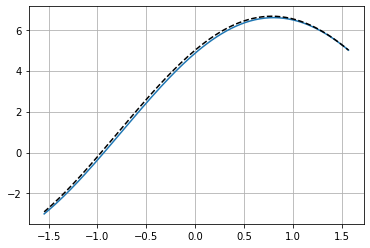

In [428]:
# Wy = F
def finite_diff_dot_method(f, g, q, x_a, x_b, dy_a, y_b, grid_size, quiet=False):
    W = np.zeros(shape=(grid_size, grid_size))
    F = np.zeros(shape=(grid_size,))
    h = (x_a - x_b) / (grid_size - 1)
    x = np.linspace(x_a - h, x_b, grid_size)
    
    # Initial conditions
    W[0, 0] = 1
    W[0, 2] = -1
    F[0] = 2 * h * dy_a
    
    W[-1, -1] = 1
    F[-1] = y_b
    
    for i in range(1, grid_size - 1):
        W[i, i-1] = 2 - h * f(x[i])
        W[i, i] = - 4 + 2 * g(x[i]) * (h ** 2)
        W[i, i+1] = 2 + h * f(x[i])
        F[i] = 2 * (h**2) * q(x[i])
    
#     y = tridiagonal(W, F)
    y = np.linalg.solve(W, F)
    
    if not quiet:
        plt.plot(x, y)

        plt.plot(x, analytical_solution(x), "k--")
        plt.grid()
    return {'x': np.array(x),'y_numerical': np.array(y), 'y_analytical': np.array(analytical_solution(x))}


analytical_solution = lambda x: 4 * np.sin(x) + 4 * np.cos(x) + 1
solution = finite_diff_dot_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=-np.pi/2, x_b=np.pi / 2, dy_a = 4, y_b = 5, grid_size=128,
)

In [415]:
analytical_solution = lambda x: 4 * np.sin(x) + np.cos(x) + 1
solution_der = lambda x: 4 * np.cos(x) - np.sin(x)
shooting = lambda steps_num: shooting_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=0., x_b=np.pi / 2, y_a = 2, y_b = 5, steps_num=steps_num, quiet=True,
)
# plt.show()


shooting_linear = lambda steps_num: shooting_linear_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=0., x_b=np.pi / 2, y_a = 2, y_b = 5, steps_num=steps_num, quiet=True,
)
# plt.show()


finite_diff = lambda grid_size: finite_diff_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=0., x_b=np.pi / 2, y_a = 2, y_b = 5, grid_size=grid_size, quiet=True,
)
# plt.show()

In [416]:
steps_linspace = [2 ** x for x in range(4, 10)]

In [417]:
def get_error_log(method, steps, m=1.): # steps contain steps number
    result = {'step len': [], 'max error': []}
    points = len(steps_linspace)
    for current_steps in steps_linspace:
        solution = method(current_steps)
        step_len = np.abs(solution['x'][0] - solution['x'][-1]) / current_steps
        y_numerical = solution['y_numerical']
        y_analytical = solution['y_analytical']
        result['step len'].append(step_len)
        result['max error'].append(
            np.max(np.abs(y_numerical - y_analytical))
        )
    result['step len'], result['max error'] = np.array(result['step len']), np.array(result['max error'])
    result['max error'] /= ((np.zeros(points) + m) ** np.array(list(range(points))))
    return result

[3.85340946 3.92018051 3.96027057 3.98016885 3.99007807]


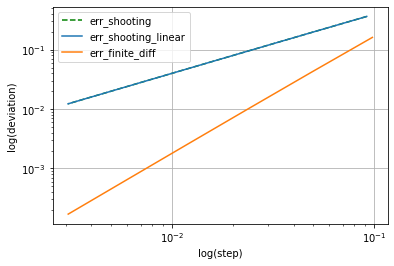

err_shooting: y=0.996428x+(1.367133)
err_shooting_linear: y=0.996419x+(1.367134)
err_finite_diff: y=1.979804x+(2.786799)


In [431]:
err_shooting = get_error_log(shooting, steps)
err_shooting_linear = get_error_log(shooting_linear, steps)
err_finite_diff = get_error_log(finite_diff, steps, m=2.)

print(err_finite_diff['max error'][:-1] / err_finite_diff['max error'][1:])

plt.loglog(err_shooting['step len'], err_shooting['max error'], "g--", label = "err_shooting")
plt.loglog(err_shooting_linear['step len'], err_shooting_linear['max error'], label = "err_shooting_linear")
plt.loglog(err_finite_diff['step len'], err_finite_diff['max error'], label = "err_finite_diff")

plt.xlabel('log(step)')
plt.ylabel('log(deviation)')
plt.legend()
plt.grid()
    
plt.show()


    
z11 = np.polyfit(np.log(err_shooting['step len']), np.log(err_shooting['max error']), 1)
p11 = np.poly1d(z11)
print ("err_shooting: y=%.6fx+(%.6f)"%(z11[0],z11[1]))
    
z12 = np.polyfit(np.log(err_shooting_linear['step len']), np.log(err_shooting_linear['max error']), 1)
p12 = np.poly1d(z12)
print ("err_shooting_linear: y=%.6fx+(%.6f)"%(z12[0],z12[1]))
    
z21 = np.polyfit(np.log(err_finite_diff['step len']), np.log(err_finite_diff['max error']), 1)
p21 = np.poly1d(z21)
print ("err_finite_diff: y=%.6fx+(%.6f)"%(z21[0],z21[1]))

In [432]:
analytical_solution = lambda x: 4 * np.sin(x) + 4 * np.cos(x) + 1


finite_diff_dot = lambda grid_size: finite_diff_dot_method(
    f=lambda x: 0., g=lambda x: 1., q=lambda x: 1.,
    x_a=-np.pi/2, x_b=np.pi / 2, dy_a = 4, y_b = 5, grid_size=grid_size, quiet=True,
)
# plt.show()

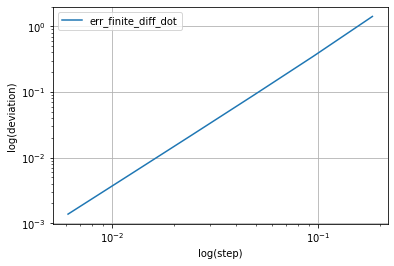

err_finite_diff_dot: y=2.038464x+(3.771233)


In [433]:
err_finite_diff_dot = get_error_log(finite_diff_dot, steps, m=2.)
plt.loglog(err_finite_diff_dot['step len'], err_finite_diff_dot['max error'], label = "err_finite_diff_dot")
plt.xlabel('log(step)')
plt.ylabel('log(deviation)')
plt.legend()
plt.grid()
    
plt.show()
    
z22 = np.polyfit(np.log(err_finite_diff_dot['step len']), np.log(err_finite_diff_dot['max error']), 1)
p22 = np.poly1d(z22)
print ("err_finite_diff_dot: y=%.6fx+(%.6f)"%(z22[0],z22[1]))

1.2875415419189262 -0.03434384356080501 0.0
-0.974609375


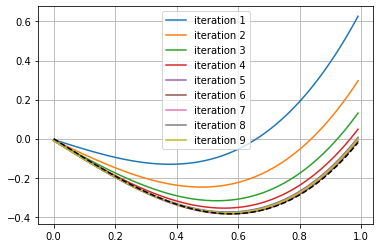

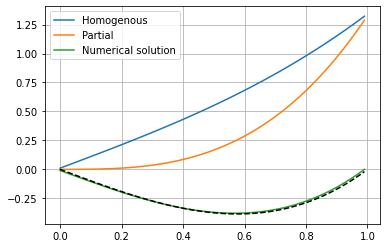

In [434]:
analytical_solution = lambda x: x*(x*x - 1)
shooting = lambda steps_num: shooting_method(
    f=lambda x: x, g=lambda x: -3., q=lambda x: 8 * x,
    x_a=0, x_b=1, y_a = 0., y_b = 0., steps_num=steps_num,
)


shooting_linear = lambda steps_num: shooting_linear_method(
    f=lambda x: x, g=lambda x: -3., q=lambda x: 8 * x,
    x_a=0, x_b=1, y_a = 0., y_b = 0., steps_num=steps_num,
)

shooting(100)
plt.show()

shooting_linear(100)
plt.show()